In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import re 
import numpy as np
import os
import pandas as pd
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf
from pyspark.sql.functions import mean, stddev
from scipy.sparse import coo_matrix
import json
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.mllib.linalg import Vectors
from pyspark.sql.functions import udf
import re

In [2]:
conf = SparkConf()
conf.set("spark.driver.maxResultSize", "3g")
# start spark master program on this machine and register worker nodes
os.system('start-spark-slurm.sh&') # use & to put it into background

# get ip address of this machine
ip = os.popen('hostname -i').read().strip('\n')
print 'Spark Master web UI: http://{}:8080'.format(ip)

Spark Master web UI: http://10.50.221.72:8080


In [3]:
spark = SparkSession.builder.master('local[60]').appName('review').getOrCreate()
df = spark.read.json('/project/cmsc25025/beer_review/labeled.json')

df.show()

+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|overall|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   3.0|On tap at the Spr...|        0|   17|  6.0|
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   4.0|On tap at the Joh...|        1|   17|  7.0|
|       4.0|  5.0|  95213|John Harvards Cri...|  3084|   14.0|   3.0|UPDATED: FEB 19, ...|        2|   33|  6.0|
|       2.0|  4.0|  65957|John Harvards Fan...|  3084|    8.0|   2.0|On tap the Spring...|        3|   33|  4.0|
|       5.0|  8.0|  41336|John Harvards Van...|  3084|   16.0|   4.0|Springfield, PA l...|        5|   58|  7.0|
|       4.0|  5.0|  80424|John Harvards Ame...|  3084|   12.0|   3.0|On tap at the Spr...|      

### Part 1. Data Inspection

To warm up, check the mean, median and standard deviation of the overall ratings for each
beer and brewer. Do you think people have similar taste?

In [4]:
beer_review = df.groupBy(df.beer_name).agg( mean(df.overall).alias("mean"), 
    stddev(df.overall).alias("std_deviation"))

In [5]:
beer_review.show()

+--------------------+------------------+------------------+
|           beer_name|              mean|     std_deviation|
+--------------------+------------------+------------------+
|      Gotlandsdricke|          12.28125|3.2051810376125354|
|            Sharps 4|14.666666666666666|1.0327955589886444|
|The Duck-Rabbit B...|              15.0|1.7320508075688772|
|Twains Billiard B...|              15.2|1.4832396974191329|
|Shady Grove Pinea...|              15.5|0.7071067811865476|
|       Hanby Cascade|11.857142857142858|2.2138425646596693|
| Lagunitas Fusion II|14.208333333333334|1.5316704909195136|
|Scotch Irish Sgt....|13.991150442477876| 2.384831437668825|
|Route 66 English ...|              11.5| 4.949747468305833|
|Good People Stron...|              15.0|               NaN|
|Iron Springs Slee...|              16.0|               NaN|
|Anglo Dutch Grand...|12.722222222222221|1.7423971167384031|
|Highland Barrel A...|13.333333333333334| 2.516611478423583|
|Great Lakes Brewi...|  

In [6]:
beer_review = df.groupBy(df.brewer).agg( mean(df.overall).alias("mean"), 
    stddev(df.overall).alias("std_deviation"))

In [7]:
beer_review.show()

+------+------------------+------------------+
|brewer|              mean|     std_deviation|
+------+------------------+------------------+
|  4590| 10.73913043478261|2.4070774269080815|
|  2040|12.470588235294118|1.9264552801775767|
|  2453|13.304347826086957|1.6358145763084648|
|  3506|              10.2|  2.16794833886788|
|  3091|12.092511013215859| 3.197798792644873|
|  2529|              15.0|               NaN|
|   474|14.855818743563336| 2.354649368096195|
|  2250|              15.0|               NaN|
|   964|12.804878048780488|2.6383660871372836|
|  1697|              11.7| 3.131045875719816|
|  5409|13.955882352941176|1.3760621246975802|
|  7279|           13.8125|1.7211914478058505|
|  4894|              11.5|2.2583179581272432|
|  2927|             10.75|1.5811388300841898|
|  1806| 9.402298850574713| 2.673990877317162|
|    26|12.615384615384615| 1.444352396804134|
|  2214|11.788461538461538| 1.563512115637933|
|  6721|15.533632286995516| 1.911908812056558|
|  2509|     

### Part 2. Labelling data

In [8]:
# First we load a vocabulary of words

with open("/project/cmsc25025/beer_review/vocab_50.json", "r") as f:
    v50 = json.load(f)

In [9]:
v50

{u'fawn': 28035,
 u'woods': 4594,
 u'spiders': 22650,
 u'hanging': 3358,
 u'woody': 385,
 u'spidery': 12742,
 u'canes': 24826,
 u'gteborg': 3306,
 u'originality': 6567,
 u'bocky': 8556,
 u'bocks': 3929,
 u'bratislava': 21396,
 u'screaming': 7757,
 u'wooded': 14149,
 u'wooden': 1458,
 u'wholemeal': 12029,
 u'getrnke': 9053,
 u'wednesday': 9783,
 u'broiled': 20387,
 u'ockbrook': 26026,
 u'crotch': 25295,
 u'stereotypical': 13536,
 u'330ml': 1259,
 u'caramell': 4478,
 u'caramelo': 12930,
 u'bbqs': 16247,
 u'sooty': 16078,
 u'scrapes': 29601,
 u'sooth': 15061,
 u'275': 7308,
 u'276': 28214,
 u'sustaining': 7325,
 u'279': 17789,
 u'scraped': 22230,
 u'errors': 22297,
 u'sliky': 22397,
 u'reeling': 22874,
 u'centimeter': 14330,
 u'cooking': 4559,
 u'hp': 16267,
 u'replaced': 3843,
 u'cherrie': 22717,
 u'succumb': 22268,
 u'shocks': 26727,
 u'widget': 4893,
 u'crouch': 15259,
 u'backtoback': 17413,
 u'cremig': 20516,
 u'china': 8627,
 u'balaced': 14509,
 u'headno': 19369,
 u'retronasally': 18

1) Generating features. You need to represent text reviews in terms of a vector of features
(covariates). One simple but effective representation is to use membership in a fixed vocabulary.
Suppose the vocabulary contains p words. For a given review, you normalize the text,
and separate it into space-delimited tokens. For each of the tokens, if it is in the dictionary
you have a one for the corresponding word in the feature vector, and you ignore it otherwise.

In [10]:
# Next we define useful functions to transform dataset 

def convert_vector(x):
    word_list = [w for w in x[1] if w in v50.keys()]
    indexes = [v50[i] for i in word_list]
    col = np.array(indexes)
    row = np.ones(len(indexes))
    row.fill(0)
    data = np.ones(len(indexes))
    
    vector = coo_matrix((data, (row, col)), shape = ( 1, len(v50.keys()))).toarray()
    
    if x[0] >= 14:
        value = 1
    else:
        value = 0
   
    label = np.array(value)
    
    return (label, vector)
    

In [11]:
def add(x,y):
    matrix = np.vstack([x[1],y[1]])
    label = np.vstack([x[0],y[0]])
    return label, matrix
    

An example of use can be seen here

In [12]:
batches = df.rdd.randomSplit(list(np.repeat(1,1000)))
feature_set = batches[1].map(lambda x: (x.overall, x.review.split(" "))).map(convert_vector).take(5)
feature_set

[(array(0), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])),
 (array(0), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])),
 (array(1), array([[ 0.,  1.,  0., ...,  0.,  0.,  0.]])),
 (array(1), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])),
 (array(1), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]))]

(2) Stochastic gradient descent. The next job is to train an 2-regularized logistic regression
classifier using stochastic gradient descent. As we process a
review, we update our model using the (stochastic) gradient computed on that review. We will
use a variant algorithm called mini-batch SGD:

In [13]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [14]:
def update_grad( weights, learning_rate, X, y, lambd):
    
    score = sigmoid(np.dot(X,weights))
    loss = y - score
    weights = weights + learning_rate * (np.dot(X.T, loss) - lambd*weights)
    
    return weights
    
    

In [15]:
def map_likelihood(X):
    scores = np.dot(X[1], weights)
    ll = X[0]*scores - np.log(1 + np.exp(scores))
    return ll[0][0]

In [16]:
def reduce_likelihood(ll1, ll2):
    
    return np.sum(ll1, ll2)
    

In [17]:
def log_likelihood(X, Y, weights):
    scores = np.dot(X, weights)
    ll = Y*scores - np.log(1 + np.exp(scores))
    return sum(ll[0]) / len(X)

In [18]:
def map_error_rate(X):
    final_scores = sigmoid(np.dot(X[1], weights))
    final_scores[ final_scores > .5] = 1
    final_scores[ final_scores <= .5] = 0
    
    return np.power((final_scores - x[0]),2) / len(final_scores)
    

In [19]:
def reduce_error_rate(er1, er2):
    
    return np.sum(er1, er2)
    

In [20]:
def error_rate(X, Y, weights):
    final_scores = sigmoid(np.dot(X, weights))
    final_scores[ final_scores > .5] = 1
    final_scores[ final_scores <= .5] = 0
    
#     float(sum(final_scores == Y)) / len(final_scores)
    return np.sum(np.power((final_scores - Y),2) / len(final_scores))

In [74]:
def epoch_text(df, val_Y, val_X, tr_Y, tr_X, C1, C2, lambda_, log_train, error_train, log_test, error_test, weights):
    
    batches = df

    
    
    print "Ready to get batch"
    
    #Get batches
    for i in range(150):
        values = batches[i].map(lambda x: (x.overall, x.review.split(" "))).map(convert_vector)
        label, feature_set = values.reduce(add)

        print i, " Batch obtained"

        #Update B
        learning_rate = C1 / (i+1)**C2
        weights = update_grad( weights, learning_rate, feature_set, label, lambda_)
        
        ll = log_likelihood(val_X, val_Y, weights)
        log_test.append(ll)

        er = error_rate(val_X, val_Y, weights)
        error_test.append(er)

        llb = log_likelihood(tr_X, tr_Y, weights)
        log_train.append(llb)

        erb = error_rate(tr_X, tr_Y, weights)
        error_train.append(erb)


        print("Log likelihood ", ll)
        print("Error ", er)
        
       


In [75]:
def run_model_text(df, C1, C2, lambda_, iterations, weights):
    ll_test = []
    er_test = []
    ll_train = []
    er_train = []
    
    train, test, val = df.rdd.randomSplit([.7, .15, .15])
    for i in range(iterations):
        
        validation = val.randomSplit(list(np.repeat(1,10000)))
        val_Y, val_X = validation[0].map(lambda x: (x.overall, 
                                                    x.review.split(" "))).map(convert_vector).reduce(add)
        
        
        training = train.randomSplit(list(np.repeat(1,10000)))
        tr_Y, tr_X = training[0].map(lambda x: (x.overall, 
                                                    x.review.split(" "))).map(convert_vector).reduce(add)
        
        epoch_text(training, val_Y, val_X, tr_Y, tr_X, C1, C2, lambda_, ll_train, er_train, ll_test, er_test, weights )
        
    return ll_test, er_test, ll_train, er_train
        
        

In [ ]:
train, test, validation = df.rdd.randomSplit([.7, .15, .15])
val_Y, val_X = validation[0].map(lambda x: (x.overall, 
                                                    x.review.split(" "))).map(convert_vector).reduce(add)


In [76]:
#Initialize B
weights = np.ones(len(v50.keys())).reshape(len(v50.keys()), 1)
weights.fill(0)
l_t, e_t, l_tr, e_tr  = run_model_text(df, C1 = .5, C2 = 1.25, lambda_ = .001, iterations = 5, weights = weights)

Ready to get batch
0  Batch obtained
('Log likelihood ', -0.11480428365479456)
('Error ', 0.45714285714285713)
1  Batch obtained
('Log likelihood ', -0.0075391407699126126)
('Error ', 0.34285714285714286)
2  Batch obtained
('Log likelihood ', -0.011106425289987945)
('Error ', 0.34285714285714286)
3  Batch obtained
('Log likelihood ', -0.01952643504644383)
('Error ', 0.34285714285714286)
4  Batch obtained
('Log likelihood ', -0.016392985627345022)
('Error ', 0.34285714285714286)
5  Batch obtained
('Log likelihood ', -0.014423613253537153)
('Error ', 0.34285714285714286)
6  Batch obtained
('Log likelihood ', -0.014347394723032132)
('Error ', 0.34285714285714286)
7  Batch obtained
('Log likelihood ', -0.015920749361296831)
('Error ', 0.34285714285714286)
8  Batch obtained
('Log likelihood ', -0.014747362045581316)
('Error ', 0.34285714285714286)
9  Batch obtained
('Log likelihood ', -0.016074862746963622)
('Error ', 0.31428571428571428)
10  Batch obtained
('Log likelihood ', -0.0166735016

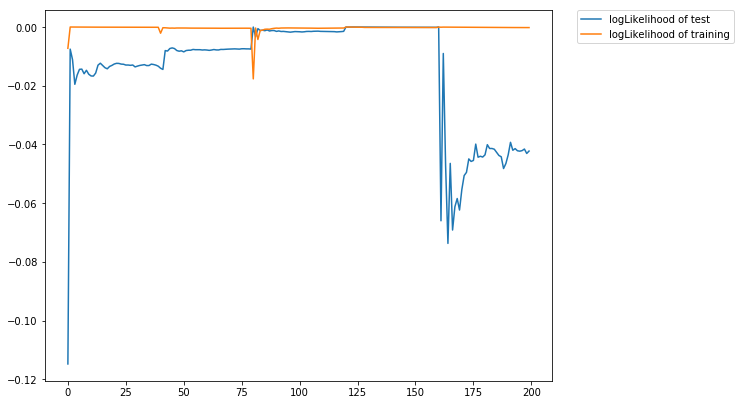

In [93]:
plt.figure(figsize=(20,15))
plt.subplot(223)
plt.plot(l_t, label="logLikelihood of test")
plt.plot(l_tr, label="logLikelihood of training")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

If we zoom into the iterations for log likelihood, we can see it follows and ascending trend

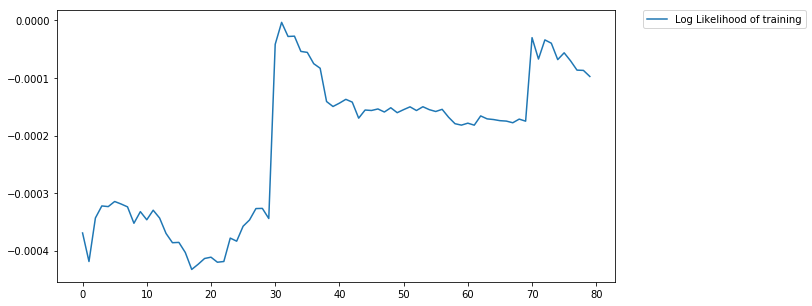

In [102]:
plt.figure(figsize=(10,5))
plt.plot(l_tr[90:170], label = 'Log Likelihood of training')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

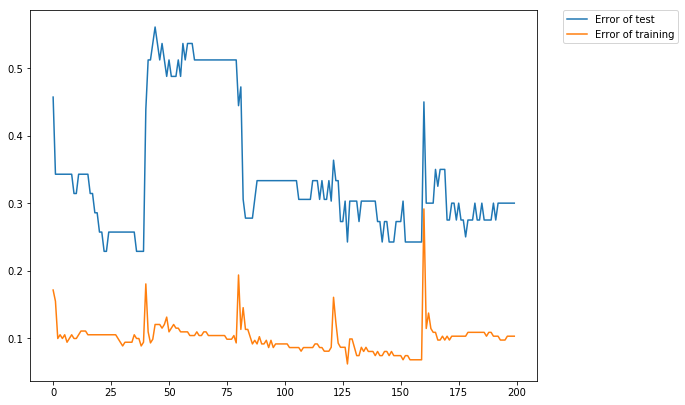

In [91]:
plt.figure(figsize=(20,15))
plt.subplot(224)
plt.plot(e_t, label="Error of test")
plt.plot(e_tr, label="Error of training")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Part C. Score versus Text

In [23]:
def convert_features(x):
    
    vector = x[1]
    
    if x[0] >= 14:
        value = 1
    else:
        value = 0
   
    label = np.array(value)
    
    return (label, vector)
    

In [38]:
def epoch(batches, C1, C2, lambda_, log_list, error_list, all_label, all_feature_set, weights):
    
    #print "Ready to get batch"
    
    #Get batches
    for i in range(100):
        values = batches[i].map(lambda x: (x.overall, 
                                           np.array([x.appearance, x.aroma, 
                                                    x.palate, x.style, x.taste ]))).map(convert_features)
        label, feature_set = values.reduce(add)

        # print i, " Batch obtained"
        
        #Update B
        learning_rate = C1 / (i+1)**C2
        weights = update_grad( weights, learning_rate, feature_set, label, lambda_)

        ll = log_likelihood(all_feature_set, all_label, weights)
        log_list.append(ll)


        er = error_rate(all_feature_set, all_label, weights)
        error_list.append(er)
        
    print("Log likelihood ", ll)
    print("Error ", er)
    
    return weights 



In [39]:
def run_model(df, C1, C2, lambda_, iterations):
    
    batches = df.randomSplit(list(np.repeat(1,500)))
    #Initialize B
    weights = np.ones(5).reshape(5, 1)
    weights.fill(0)
    
    # Get large feature set 
    
    print "Get large data set"
    all_label, all_feature_set =  df.map(lambda x: (x.overall, 
                                           np.array([x.appearance, x.aroma, 
                                                    x.palate, x.style, 
                                                     x.taste ]))).map(convert_features).reduce(add)
    
    ll_list = []
    er_list = []
    
    for i in range(iterations):
        weights = epoch(batches, C1, C2, lambda_, ll_list, er_list, all_label, all_feature_set, weights)
        
    return ll_list, er_list, weights
        

In [30]:
train, test, validation = df.rdd.randomSplit([.7, .15, .15])
l, e, w = run_model(train, C1 = .0001, C2 = 1.25, lambda_ = .001, iterations = 3)

Get large data set
Ready to get batch
0  Batch obtained
('Log likelihood ', -4.6291182175222286e-06)
('Error ', 0.46286495076937423)
1  Batch obtained
('Log likelihood ', 0.0)
('Error ', 0.53713504923062616)
2  Batch obtained
('Log likelihood ', -8.1964897643182962e-10)
('Error ', 0.52976323466148567)
3  Batch obtained
('Log likelihood ', -9.6145967737443212e-06)
('Error ', 0.46286495076937423)
4  Batch obtained
('Log likelihood ', -6.2815383275980751e-07)
('Error ', 0.43512659591026542)
5  Batch obtained
('Log likelihood ', -6.6159277877987433e-06)
('Error ', 0.46286495076937423)
6  Batch obtained
('Log likelihood ', -7.7402388911807371e-07)
('Error ', 0.42680997144893634)
7  Batch obtained
('Log likelihood ', -4.8689523258392623e-06)
('Error ', 0.46286495076937423)
8  Batch obtained
('Log likelihood ', -5.4252620216735377e-07)
('Error ', 0.43867092529913748)
9  Batch obtained
('Log likelihood ', -3.3984942452646266e-06)
('Error ', 0.46286495076937423)
10  Batch obtained
('Log likelih

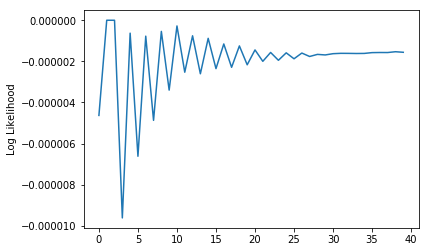

In [31]:
plt.plot(l)
plt.ylabel('Log Likelihood')

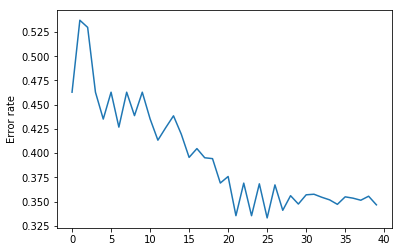

In [32]:
plt.plot(e)
plt.ylabel('Error rate')

#### Use cross-validation to select lambda

In [40]:
#Now we tune the parameters to select lambda 

lambda_list = [.001, .002, .01, .05, .1, .5]
for lambda_ in lambda_list: 
    best_error = 10e10
    best_lambda = 0 
    best_weights = []
    l, e, w = run_model(validation, C1 = .0001, C2 = 1.25, lambda_ = lambda_, iterations = 5)
    error = min(e)
    if error < best_error:
        best_error = error
        best_lambda = lambda_
        best_weights = w
    
    

Get large data set
('Log likelihood ', -1.0351059319419657e-06)
('Error ', 0.35495143856366751)
('Log likelihood ', -8.8579937464820563e-07)
('Error ', 0.35387886656828027)
('Log likelihood ', -8.5966777129357843e-07)
('Error ', 0.35309392666188172)
('Log likelihood ', -8.5157643519344178e-07)
('Error ', 0.35196490350884274)
('Log likelihood ', -8.45236176149942e-07)
('Error ', 0.35045416300406174)
Get large data set
('Log likelihood ', -1.1377401108582972e-06)
('Error ', 0.34727139297263732)
('Log likelihood ', -9.9910280528177991e-07)
('Error ', 0.35006169305086243)
('Log likelihood ', -9.6124200406266531e-07)
('Error ', 0.35002137079539691)
('Log likelihood ', -9.4571382162815027e-07)
('Error ', 0.34770418518130236)
('Log likelihood ', -9.361238543181451e-07)
('Error ', 0.34747838055069458)
Get large data set
('Log likelihood ', -1.1166095549297376e-06)
('Error ', 0.3472445114689936)
('Log likelihood ', -9.4037738567398237e-07)
('Error ', 0.34680634295959983)
('Log likelihood ', -9.

In [41]:
print best_lambda, best_error

0.5 0.331483885883


In [42]:
# Train model with val and test set 

val_train = validation + train 
final_l, final_e, final_w = run_model(val_train, C1 = .0001, C2 = 1.25, lambda_ = best_lambda, iterations = 5)

Get large data set
('Log likelihood ', -3.9421868756044878e-08)
('Error ', 0.35261706294182832)
('Log likelihood ', -1.0147192273499818e-07)
('Error ', 0.34621460285249961)
('Log likelihood ', -1.0572773317436143e-07)
('Error ', 0.34091621101569514)
('Log likelihood ', -1.0018269426722368e-07)
('Error ', 0.33674886209510807)
('Log likelihood ', -9.5767803145375776e-08)
('Error ', 0.32961146073009528)


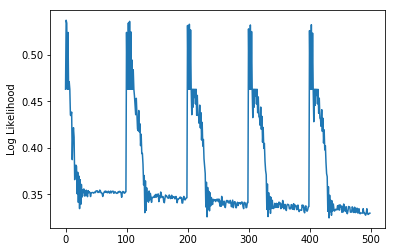

In [44]:
plt.plot(final_e)
plt.ylabel('Log Likelihood')

#### Compute error rate on test set

In [50]:
test_label, test_feature_set =  test.map(lambda x: (x.overall, 
                                           np.array([x.appearance, x.aroma, 
                                                    x.palate, x.style, 
                                                     x.taste ]))).map(convert_features).reduce(add)

final_error = error_rate(test_feature_set, test_label, final_w)

print "Final MSE for test is ", final_error

Final MSE for test is  0.329617365119


### Part D. Build own classifier

In [40]:
train, test = df.rdd.randomSplit([.7,.3])

In [41]:
train_pos = train.filter( lambda x: x.overall >= 14)
test_pos = train.filter( lambda x: x.overall >= 14)

In [42]:
train_neg = train.filter( lambda x: x.overall < 14)
test_neg = train.filter( lambda x: x.overall < 14)

In [6]:

stop_words = ['a', 'able', 'about', 'across', 'after', 'all', 'almost', 'also',
              'am', 'among', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because',
              'been', 'but', 'by', 'can', 'cannot', 'could', 'dear',
              'did', 'do', 'does', 'either', 'else', 'ever', 'every', 'for',
              'from', 'get', 'got', 'had', 'has', 'have', 'he', 'her', 'hers',
              'him', 'his', 'how', 'however', 'i', 'if', 'in', 'into', 'is',
              'it', 'its', 'just', 'least', 'let', 'like', 'likely', 'may',
              'me', 'might', 'most', 'must', 'my', 'neither', 'no', 'nor',
              'not', 'of', 'off', 'often', 'on', 'only', 'or', 'other', 'our',
              'own', 'rather', 'said', 'say', 'says', 'she', 'should', 'since',
              'so', 'some', 'than', 'that', 'the', 'their', 'them', 'then',
              'there', 'these', 'they', 'this', 'tis', 'to', 'too', 'twas', 'us',
              've', 'wants', 'was', 'we', 'were', 'what', 'when', 'where', 'which',
              'while', 'who', 'whom', 'why', 'will', 'with', 'would', 'yet',
              'you', 'your']

In [43]:
def parse(blob):
    blob = blob.review.split()
    blob = [re.sub('[^A-Za-z]', '', i) for i in blob]
    blob = [word.strip().lower() for word in blob if word not in stop_words if len(word) >= 3]
    return blob

In [44]:
# Parse Text into Words
train_pos_bag = train_pos.map(parse)
train_neg_bag = train_neg.map(parse)
test_pos_bag = test_pos.map(parse)
test_neg_bag = test_neg.map(parse)

In [45]:
# TF Mapping
train_tf_pos = HashingTF().transform(train_pos_bag)
train_tf_neg = HashingTF().transform(train_neg_bag)
test_tf_pos = HashingTF().transform(test_pos_bag)
test_tf_neg = HashingTF().transform(test_neg_bag)

In [46]:
# IDF Transformation
train_idf_pos = IDF().fit(train_tf_pos)
train_idf_neg = IDF().fit(train_tf_neg)
test_idf_pos = IDF().fit(test_tf_pos)
test_idf_neg = IDF().fit(test_tf_neg)

train_tfidf_pos = train_idf_pos.transform(train_tf_pos)
train_tfidf_neg = train_idf_neg.transform(train_tf_neg)
test_tfidf_pos = test_idf_pos.transform(test_tf_pos)
test_tfidf_neg = test_idf_neg.transform(test_tf_neg)

In [47]:
# Label Positive and Negative
train_tfidf_pos = train_tfidf_pos.map(lambda x: LabeledPoint(1, x))
train_tfidf_neg = train_tfidf_neg.map(lambda x: LabeledPoint(0, x))
test_tfidf_pos = test_tfidf_pos.map(lambda x: LabeledPoint(1, x))
test_tfidf_neg = test_tfidf_neg.map(lambda x: LabeledPoint(0, x))

In [48]:
# Join Positive and Negative
train_all_tfidf = train_tfidf_pos.union(train_tfidf_neg)
test_all_tfidf = test_tfidf_pos.union(test_tfidf_neg)

train_all_tfidf.cache()
test_all_tfidf.cache()

UnionRDD[116] at union at NativeMethodAccessorImpl.java:0

In [49]:
#### TRAIN SET ACCURACY ####

train_data, test_data = train_all_tfidf.randomSplit([0.6, 0.4], seed = 0)

model_train = NaiveBayes.train(train_data)
predictionAndLabel = test_data.map(lambda p : (model_train.predict(p.features), p.label))
train_accuracy = 1.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / test_data.count()
print "TRAINING ACCURACY:  ", train_accuracy

TRAINING ACCURACY:   0.719687255265


In [50]:
#### TEST SET ACCURACY ####

model_test = NaiveBayes.train(train_all_tfidf)
predictionAndLabel = test_all_tfidf.map(lambda p : (model_test.predict(p.features), p.label))
test_accuracy = 1.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / test_all_tfidf.count()
print "TEST ACCURACY:  ", test_accuracy

TEST ACCURACY:   0.770696680609


#### Now predict labels for unlabelled data

In [16]:
unlabeled = spark.read.json('/project/cmsc25025/beer_review/unlabeled.json')
unlabeled.show()

+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
|       2.0|  4.0|  65957|John Harvards Fan...|  3084|   2.0|On tap at the Spr...|        4|   33|  4.0|
|       4.0|  5.0|  19708|John Harvards Dr....|  3084|   4.0|From Springfield ...|       12|   60|  7.0|
|       3.0|  6.0|  21566|Barley Island Bar...|  1786|   3.0|GTMW 08 on cask -...|       19|   66|  6.0|
|       3.0|  7.0| 108906|Barley Island Dir...|  1786|   3.0|Handbottled, cour...|       25|   57|  7.0|
|       4.0|  7.0| 108906|Barley Island Dir...|  1786|   3.0|Bottled. Amber co...|       30|   57|  7.0|
|       3.0|  8.0| 108906|Barley Island Dir...|  1786|   4.0|Had this on tap l...|       35|   57|  9.0|
|       4.0|  6.0|  72141|Barley Island Sin...|  1786| 

In [25]:
#Transform unlabeled data to a tfidf hashed vector
u_bag = unlabeled.rdd.map(parse)
utf = HashingTF().transform(u_bag)
idf = IDF().fit(utf)
tfidf = idf.transform(utf)

In [55]:
#Get review id from data
ids = unlabeled.rdd.map(lambda x: x.review_id)
ids.take(5)

[4, 12, 19, 25, 30]

In [56]:
#Zip the review and the hashed vector into a labeled point object
dataset = ids.zip(tfidf).map(lambda x: LabeledPoint(x[0], x[1]))

In [26]:
#Check each point has the same structure than the training data
t = tfidf.map(lambda x: LabeledPoint(1, x))
t.take(1)

[LabeledPoint(1.0, (1048576,[3714,26175,33833,35730,38453,44483,94754,130292,131329,200110,202225,202396,257110,273037,322824,368831,383424,448747,522628,618507,629109,639136,648593,688949,699261,704697,714034,746439,752105,790293,831560,845634,892211,907456,920335,921720,965510,1010110,1026437],[11.0436438607,5.81253524386,7.44437656529,3.08356957704,5.73255130268,1.21633565492,3.12517117712,3.6125134619,2.1037258469,9.81150017942,7.20572882744,2.68063468302,8.88405123712,6.01134026714,1.6134338623,6.3341136594,3.12127921299,3.14010034573,2.63553238576,2.73978534248,2.15735320536,3.45966959219,5.02574605654,6.43277565361,2.29074633594,4.43121887502,1.24348713901,3.23155476398,1.29399037147,4.02895787091,2.42828242197,0.399331827352,2.58075601416,1.60681695998,2.12146186508,2.2150032433,3.08841922282,9.43420594828,3.35231324897]))]

In [62]:
#Predict values with NB trained model 
dataset.map(lambda p : (p.label, model_test.predict(p.features))).take(5)

[(4.0, 0.0), (12.0, 0.0), (19.0, 1.0), (25.0, 0.0), (30.0, 0.0)]

In [63]:
predictions = dataset.map(lambda p : (p.label, model_test.predict(p.features))).collectAsMap()

In [69]:
with open('assn3_prob4_predict.json', 'w') as f:
    json.dump(predictions, f)